# Training an entities recognition model

Importing the required code files

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

from entities_recognition.bilstm.train import trainIters, evaluate_all
from config import START_TAG, STOP_TAG

In [2]:
print(BASE_PATH)

/Users/2359media/Documents/botbot-nlp


The training data must be an array that:
- Contains tuples of (sentence, tags)
- Sentence will be splitted using nltk.wordpunct_tokenize
- Tags will be splitted using .split() - hence spaces by default

Each entity must be separated into 3 kinds of tag: B- (Begin), I- (Inside) and O- (Outside)

_This is to help with separation in the case of consecutive entities_

A `dictionary` to translate from these tags into consecutive indices must be defined
This dictionary will contain:
- The empty token
- `START_TAG` and `END_TAG` tokens (imported from global configs - used internally to indicate start and end of sentence)
- Entities B-, I-, O- tokens

**Sample training data for email recognition:**

In [3]:
training_data = [(
    'My email address is at luungoc2005@gmail.com.',
    '- - - - - - - - - - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL -'
), (
    'Contact me at contact@2359media.net.',
    '- - - - - - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL -'
), (
    'test.email@microsoft.com is a testing email address',
    'B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL - - - - - - - - - -'
), (
    'Any inquiries email thesloth_197@gmail.com for assistance',
    '- - - - - - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL - - - -'
), (
    'Email addresses include test.noreply@gmail.com hello.vietnam@hallo.org contact@rocket.net',
    '- - - - - - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL'
), (
    'Contact: tester@github.com at any hours',
    '- - - B-EMAIL I-EMAIL I-EMAIL I-EMAIL I-EMAIL - - - - - -'
)]

tag_to_ix = {
    '-': 0, # O tag but using '-' for readability
    'B-EMAIL': 1,
    'I-EMAIL': 2,
    START_TAG: 3,
    STOP_TAG: 4
}

In [4]:
from entities_recognition.bilstm.predict import read_tags
from common.utils import wordpunct_space_tokenize

result = []
for sentence, tag_seq in training_data:
    tokens_in = wordpunct_space_tokenize(sentence)
    assert len(tokens_in) == len(tag_seq.split(' '))
    print(read_tags(tokens_in, tag_seq.split(' ')))

{'EMAIL': ['luungoc2005@gmail.com']}
{'EMAIL': ['contact@2359media.net']}
{'EMAIL': ['test.email@microsoft.com']}
{'EMAIL': ['thesloth_197@gmail.com']}
{'EMAIL': ['test.noreply@gmail.com', 'hello.vietnam@hallo.org', 'contact@rocket.net']}
{'EMAIL': ['tester@github.com']}


Begin training the network
Logs will be saved into `entities_recognition/bilstm/logs` by default

Run `tensorboard --logdir=entities_recognition/bilstm/logs` from the root directory for training logs

Verbosity:
- `verbose = 0` for almost no console output
- `verbose = 1` will only log on `log_every` (10 epochs by default)
- `verbose = 2` (default) will use tqdm for both loops

In this case ~50 epochs should be sufficient (found by trial and error)

In [5]:
losses, model = trainIters(training_data, 
                           tag_to_ix,
                           learning_rate=0.1,
                           optimizer='sgd',
                           gradual_unfreeze=True,
                           n_iters=50,
                           log_every=5,
                           verbose=1)

Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
0m 7s (- 1m 11s) (5 10%) 139.7047
0m 10s (- 0m 40s) (10 20%) 52.9345
0m 12s (- 0m 28s) (15 30%) 4.6199
0m 14s (- 0m 21s) (20 40%) 2.0055
0m 16s (- 0m 16s) (25 50%) 0.9614
0m 19s (- 0m 12s) (30 60%) 0.6788
0m 22s (- 0m 9s) (35 70%) 0.3863
0m 25s (- 0m 6s) (40 80%) 0.3236
0m 28s (- 0m 3s) (45 90%) 0.2924
0m 30s (- 0m 0s) (50 100%) 0.2476


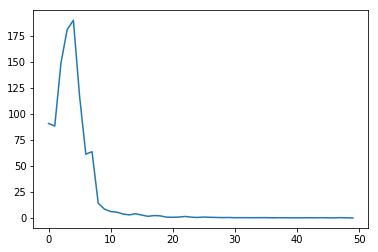

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=25)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

Evaluate model accuracy by using

In [7]:
evaluate_all(model, training_data, tag_to_ix)

1.0